In [16]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import numpy as np
import matplotlib.pyplot as plt

2.0.0


In [2]:
from model.smooth_cross_entropy import smooth_crossentropy

from utility.log import Log

from utility.initialize import initialize
from utility.step_lr import StepLR
from utility.bypass_bn import enable_running_stats, disable_running_stats

import sys; sys.path.append("..")
from sam import SAM


## Link to Dataset
[`TUDataset`](https://chrsmrrs.github.io/datasets/docs/datasets/)

# Graph Classification with Graph Neural Networks

In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:3500]
test_dataset = dataset[3500:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 3500
Number of test graphs: 837


## Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension:

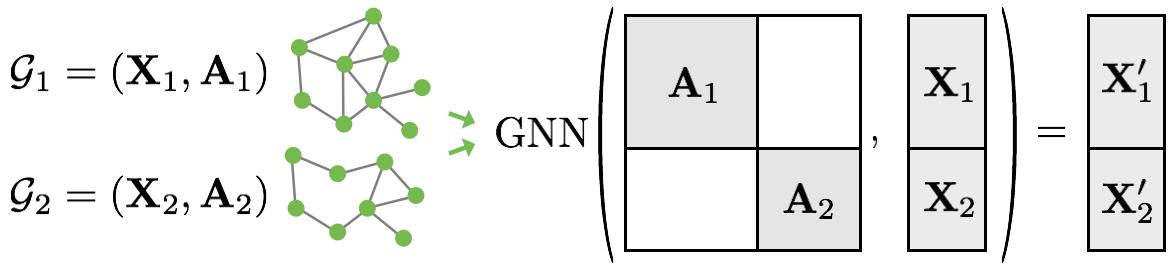

This procedure has some crucial advantages over other batching procedures:

1. GNN operators that rely on a message passing scheme do not need to be modified since messages are not exchanged between two nodes that belong to different graphs.

2. There is no computational or memory overhead since adjacency matrices are saved in a sparse fashion holding only non-zero entries, *i.e.*, the edges.

PyTorch Geometric automatically takes care of **batching multiple graphs into a single giant graph** with the help of the [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader) class:

In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 4330], x=[2152, 14], edge_attr=[4330, 3], y=[64], batch=[2152], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3656], x=[1770, 14], edge_attr=[3656, 3], y=[64], batch=[1770], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3772], x=[1840, 14], edge_attr=[3772, 3], y=[64], batch=[1840], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3826], x=[1842, 14], edge_attr=[3826, 3], y=[64], batch=[1842], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3944], x=[1897, 14], edge_attr=[3944, 3], y=[64], batch=[1897], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 3768], x=[1827, 14], edge_attr=[3768, 3], y=[64], batch=[1827], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 4072], x=[1968, 14], edge

Here, we opt for a `batch_size` of 64, leading to 3 (randomly shuffled) mini-batches, containing all $2 \cdot 64+22 = 150$ graphs.

Furthermore, each `Batch` object is equipped with a **`batch` vector**, which maps each node to its respective graph in the batch:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$

## Training a Graph Neural Network (GNN)

Training a GNN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

There exists multiple **readout layers** in literature, but the most common one is to simply take the average of node embeddings:

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$

PyTorch Geometric provides this functionality via [`torch_geometric.nn.global_mean_pool`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.glob.global_mean_pool), which takes in the node embeddings of all nodes in the mini-batch and the assignment vector `batch` to compute a graph embedding of size `[batch_size, hidden_channels]` for each graph in the batch.

The final architecture for applying GNNs to the task of graph classification then looks as follows and allows for complete end-to-end training:

In [7]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv
from torch_geometric.nn import global_mean_pool
from torchinfo import summary

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, 2*hidden_channels)
        self.conv3 = GraphConv(2*hidden_channels, 2*hidden_channels)
        self.conv4 = GraphConv(2*hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GraphConv: 1-1                         --
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       960
│    └─Linear: 2-3                       896
├─GraphConv: 1-2                         --
│    └─SumAggregation: 2-4               --
│    └─Linear: 2-5                       8,320
│    └─Linear: 2-6                       8,192
├─GraphConv: 1-3                         --
│    └─SumAggregation: 2-7               --
│    └─Linear: 2-8                       16,512
│    └─Linear: 2-9                       16,384
├─GraphConv: 1-4                         --
│    └─SumAggregation: 2-10              --
│    └─Linear: 2-11                      8,256
│    └─Linear: 2-12                      8,192
├─Linear: 1-5                            130
Total params: 67,842
Trainable params: 67,842
Non-trainable params: 0

In [23]:
model = GCN(hidden_channels=64)

name_opt = 'SAM'
rho = 0.3

log = Log(log_each=10, optimizer=name_opt, rho=rho)

if name_opt == 'SGD':
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0005)

elif name_opt == 'SAM':
    base_optimizer = torch.optim.Adam
    optimizer = SAM(model.parameters(), base_optimizer, rho=rho, adaptive=True, lr=0.01, weight_decay=0.0005)

else:
    raise NotImplementedError

epochs = 5
scheduler = StepLR(optimizer, 0.01, epochs)

history = dict(loss_train = [], loss_test = [])

for epoch in range(epochs):
    model.train()
    log.train(len_dataset=len(train_dataset))

    for data in train_loader:
        input_x = data.x
        input_edge_index = data.edge_index
        input_batch = data.batch
        targets = data.y
        
        if name_opt == 'SGD':
            predictions = model(input_x, input_edge_index, input_batch)
            loss = smooth_crossentropy(predictions, targets, smoothing=0.1) # torch.Size([64])
            loss.mean().backward()
            optimizer.step()
            optimizer.zero_grad()

        elif name_opt == 'SAM':
            # first forward-backward step
            enable_running_stats(model)
            predictions = model(input_x, input_edge_index, input_batch)
            loss = smooth_crossentropy(predictions, targets, smoothing=0.1)
            loss.mean().backward()
            optimizer.first_step(zero_grad=True)

            # second forward-backward step
            disable_running_stats(model)
            smooth_crossentropy(model(input_x, input_edge_index, input_batch), targets, smoothing=0.1).mean().backward()
            optimizer.second_step(zero_grad=True)
                
        with torch.no_grad():
            correct = predictions.max(dim=1).indices == targets # torch.Size([64])
            log(model, loss.cpu(), correct.cpu(), scheduler.lr())
            scheduler(epoch)
    
    history['loss_train'].append(loss.mean().detach().numpy())

    model.eval()
    log.eval(len_dataset=len(test_dataset))

    with torch.no_grad():
        for data in test_loader:
            input_x = data.x
            input_edge_index = data.edge_index
            input_batch = data.batch
            targets = data.y
            
            predictions = model(input_x, input_edge_index, input_batch)
            loss = smooth_crossentropy(predictions, targets)
            correct = predictions.max(dim=1).indices == targets
            log(model, loss.cpu(), correct.cpu())
    
    history['loss_test'].append(loss.mean().detach().numpy())
 
log.flush()

┏━━━━━━━━━━━━━━┳━━━━━━━╸T╺╸R╺╸A╺╸I╺╸N╺━━━━━━━┳━━━━━━━╸S╺╸T╺╸A╺╸T╺╸S╺━━━━━━━┳━━━━━━━╸V╺╸A╺╸L╺╸I╺╸D╺━━━━━━━┓
┃              ┃              ╷              ┃              ╷              ┃              ╷              ┃
┃       epoch  ┃        loss  │    accuracy  ┃        l.r.  │     elapsed  ┃        loss  │    accuracy  ┃
┠──────────────╂──────────────┼──────────────╂──────────────┼──────────────╂──────────────┼──────────────┨
┃           0  ┃      0.4156  │     56.94 %  ┃   1.000e-02  │   00:03 min  ┃┈▒┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┨      0.3238  │     67.26 %  ┃
┃           1  ┃      0.2994  │     70.00 %  ┃   1.000e-02  │   00:03 min  ┃┈▒┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┨      0.3130  │     70.85 %  ┃
┃           2  ┃      0.2897  │     73.17 %  ┃   2.000e-03  │   00:03 min  ┃┈▒┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┨      0.2805  │     70.13 %  ┃
┃           3  ┃      0.2705  │     74.37 %  ┃   4.000e-04  │   00:02 min  ┃┈▒┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┈┨      0.2801  │     70.49 %  ┃
┃           4  ┃      0.

KeyboardInterrupt: 

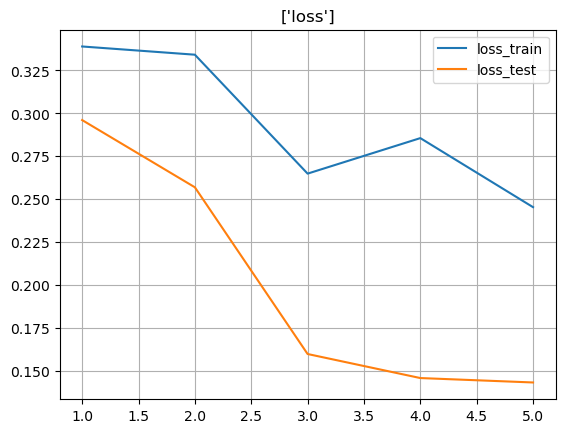

In [21]:
plt.figure()
plt.plot(np.arange(1, epochs+1), history['loss_train'])
plt.plot(np.arange(1, epochs+1), history['loss_test'])
plt.grid()
plt.legend(['loss_train', 'loss_test'])
plt.title(['loss'])
plt.show()

# plot also accuracy

In [ ]:
'''
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 10):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
'''